In [1]:
import os
import sys
from pathlib import Path
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
from tqdm.auto import tqdm
import numpy as np
from PIL import Image  
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

from torchvision.utils import make_grid
from  torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPTextModel, CLIPTokenizer, CLIPImageProcessor, Dinov2Model

import diffusers
from diffusers import (
    StableDiffusionControlNetImg2ImgPipeline,
    StableDiffusionPipelineSafe,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    # schedulers
    DDPMScheduler,
    EulerDiscreteScheduler,
    PNDMScheduler,
    # components
    UNet2DConditionModel,
    AutoencoderKL,
)

from controlnet_aux import OpenposeDetector, DWposeDetector

from utils import show_images, make_grid

/home/aliaagheis/miniconda3/envs/fast_env/lib/python3.12/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

generator = torch.Generator(device=device).manual_seed(42)

cuda


# Load Components

In [4]:
# Base model for fine-tuning
# TODO: dangerous -> add safety checker
model_id = "SG161222/Realistic_Vision_V6.0_B1_noVAE"

In [ ]:
# load unet
# in_channels = 4 (src_img || black_img) + 4 (src_pose_img || target_pose_img) 
# TODO: add channel for mask or add channel for DINOv2 make in_channels = 9 || 10
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", 
                                            torch_dtype=torch.float16, 
                                            # in_channels=8,
                                            # low_cpu_mem_usage=False,
                                            # ignore_mismatched_sizes=True
                                           ).to(device)

An error occurred while trying to fetch SG161222/Realistic_Vision_V6.0_B1_noVAE: SG161222/Realistic_Vision_V6.0_B1_noVAE does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [6]:
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.float16)
scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
# Load the image encoder to encode the image.
image_encoder = Dinov2Model.from_pretrained("facebook/dinov2-giant", torch_dtype=torch.float16)

vae = vae.to(device)
text_encoder = text_encoder.to(device)
image_encoder = image_encoder.to(device)

An error occurred while trying to fetch SG161222/Realistic_Vision_V6.0_B1_noVAE: SG161222/Realistic_Vision_V6.0_B1_noVAE does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [7]:
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet").to(device)

/home/aliaagheis/miniconda3/envs/fast_env/lib/python3.12/site-packages/controlnet_aux/open_pose/body.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.t

# Inference Loop


In [8]:
prompt = "An ultra high-resolution, photorealistic image in 8K, A highly detailed photo, showcasing vivid colors and rich contrasts, portrait photo, perfect anatomy, 4k, high quality"
negative_prompt = "nudity (deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime), text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"
# image = pipe(prompt, negative_prompt = negative_prompt, height=768, width=1024 )#.images[0]
    
# TODO: add negative_prompt
# Tokenize positive and negative prompts
positive_token_ids = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")['input_ids'].to(device)
negative_token_ids = tokenizer(negative_prompt, padding="max_length", truncation=True, return_tensors="pt")['input_ids'].to(device)

# Generate embeddings
with torch.no_grad():
    positive_embeddings = text_encoder(positive_token_ids).last_hidden_state
    negative_embeddings = text_encoder(negative_token_ids).last_hidden_state

combined_embeddings = torch.cat([negative_embeddings, positive_embeddings], dim=0).half()


  0%|          | 0/51 [00:00<?, ?it/s]

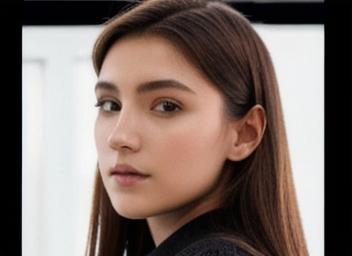

In [9]:
scheduler.set_timesteps(50)

# Prep latents, 
latents = torch.randn(
  (1, unet.config.in_channels, 256 // 8, 352 // 8),
  generator=generator,
  device=device
).half()
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]


for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    # Scale the latents (preconditioning):
    # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=combined_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + 7.0 * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


# Load Dataset

you should download the train, test dataset before

```bash
$ python ./src/scripts/download_data.py --files "train_lst_256_png, test_lst_256_png, train_data.json, test_data.json"
```

In [10]:
DATA_PATH = Path("../../datasets/fashion")

TRAIN_PATH = DATA_PATH / "train_lst_256_png/train_lst_256_png"    
TEST_PATH = DATA_PATH / "test_lst_256_png/test_lst_256_png"    
TRAIN_JSON_PATH = DATA_PATH / "train_data.json"
TEST_JSON_PATH = DATA_PATH / "train_data.json"

assert TRAIN_PATH.exists(), "No Train Dataset"
assert TRAIN_JSON_PATH.exists(), "No Train Info"
assert TEST_PATH.exists(), "No Test Dataset"
assert TEST_JSON_PATH.exists(), "No Test Info"

In [11]:
import json
class ImageDataset(Dataset):
    def __init__(self, 
                 root_dir: Path = TRAIN_PATH, 
                 info_json_path: Path = TRAIN_JSON_PATH, 
                 transform=None):
        
        assert root_dir.exists(), "No Dataset Exists"
        assert info_json_path.exists(), "No Dataset Info Exists"
        
        self.root_dir = root_dir
        self.transform = transform
        
        with open(info_json_path, 'r') as file:
            self.data = json.load(file)[:5_000] # TODO: till now -- remove it later

    def __len__(self):
        return len(self.data) # train: 99517

    def __getitem__(self, idx):
        src_path, tar_path = self.data[idx]['source_image'], self.data[idx]['target_image']
        src_path, tar_path = src_path.split(".")[0] + ".png", tar_path.split(".")[0] + ".png"
        
        src_img = Image.open(self.root_dir / src_path).convert("RGB")  # Convert to 3 channels
        tar_img = Image.open(self.root_dir / tar_path).convert("RGB")  # Convert to 3 channels

        src_mask = self.concatenate_src_mask(src_img)
        st_pose = self.concatenate_src_pose_target_pose(src_img, tar_img)
        src_tar = self.concatenate_src_tar(src_img, tar_img)
        
        if self.transform:
            src_mask  = self.transform(src_mask)
            st_pose   = self.transform(st_pose)
            src_tar   = self.transform(src_tar)

        return {"src_mask": src_mask, "st_pose": st_pose, "src_tar": src_tar} 
    
    def concatenate_src_mask(self, src_img):
        """ concatenate source with mask """
        black_image = Image.new("RGB", src_img.size, (0, 0, 0)).resize(src_img.size, Image.BICUBIC)
        
        src_mask = Image.new("RGB", (src_img.width * 2, src_img.height))
        src_mask.paste(src_img, (0, 0))
        src_mask.paste(black_image, (src_img.width, 0))

        return src_mask

    def concatenate_src_tar(self, src_img, tar_img):
        """ concatenate source with target """
        src_tar = Image.new("RGB", (src_img.width * 2, src_img.height))
        src_tar.paste(src_img, (0, 0))
        src_tar.paste(tar_img, (src_img.width, 0))

        return src_tar
    
    def concatenate_src_pose_target_pose(self, src_img: Image, tar_img: Image):
        """ concatenate source pose with target pose"""
        src_pose = openpose(src_img, image_resolution=src_img.size[1], include_body=True, include_face=True).resize(src_img.size, Image.BICUBIC)
        tar_pose = openpose(tar_img, image_resolution=src_img.size[1], include_body=True, include_face=True).resize(src_img.size, Image.BICUBIC)
        st_pose = Image.new("RGB", (src_pose.width * 2, src_pose.height))
        st_pose.paste(src_pose, (0, 0))
        st_pose.paste(tar_pose, (src_pose.width, 0))

        return st_pose

In [12]:
from torchvision import transforms

# TODO:  try different parameters
image_size = (256, 352)
batch_size = 8
accumulation_steps = 4

# Define data augmentations
tfms = transforms.Compose(
    [
        transforms.Resize(image_size),  # Resize
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

train_dataset = ImageDataset(transform = tfms)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [13]:
xs = train_dataset[0]
xb = next(iter(train_dataloader))

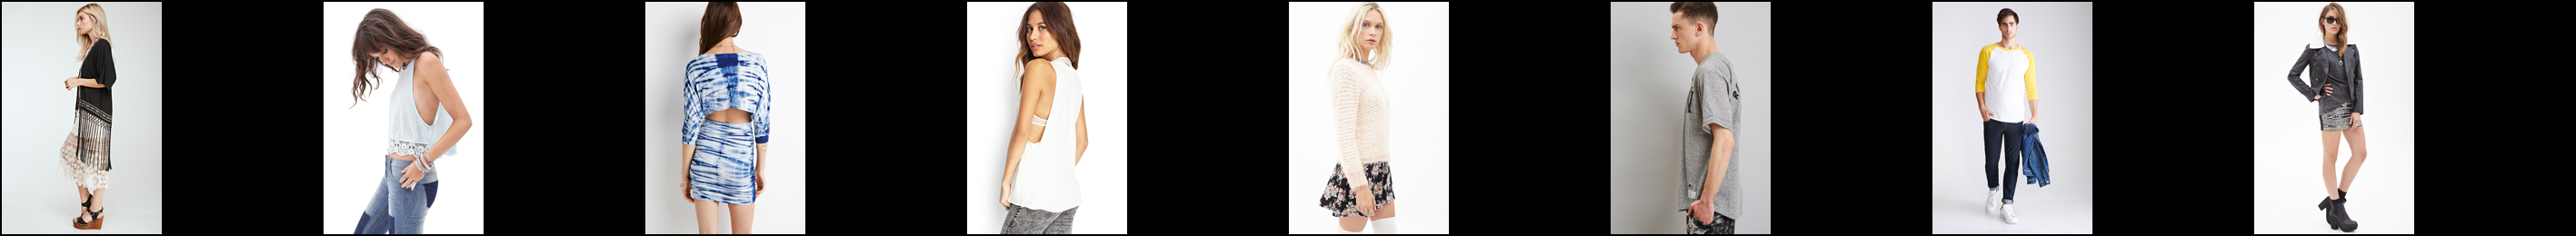

In [14]:
show_images( xb['src_mask'])

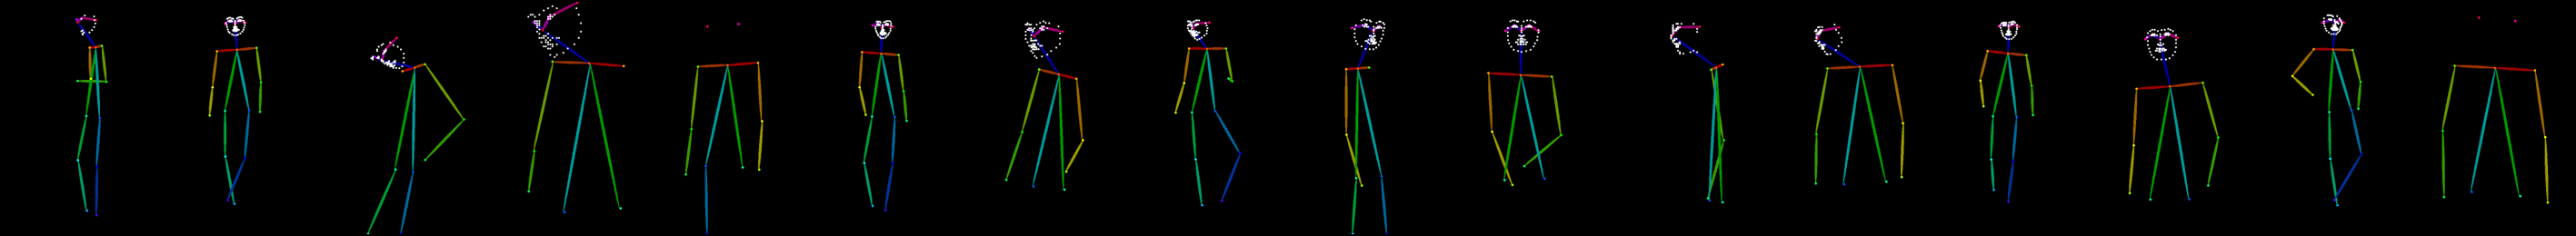

In [15]:
show_images( xb['st_pose'] )

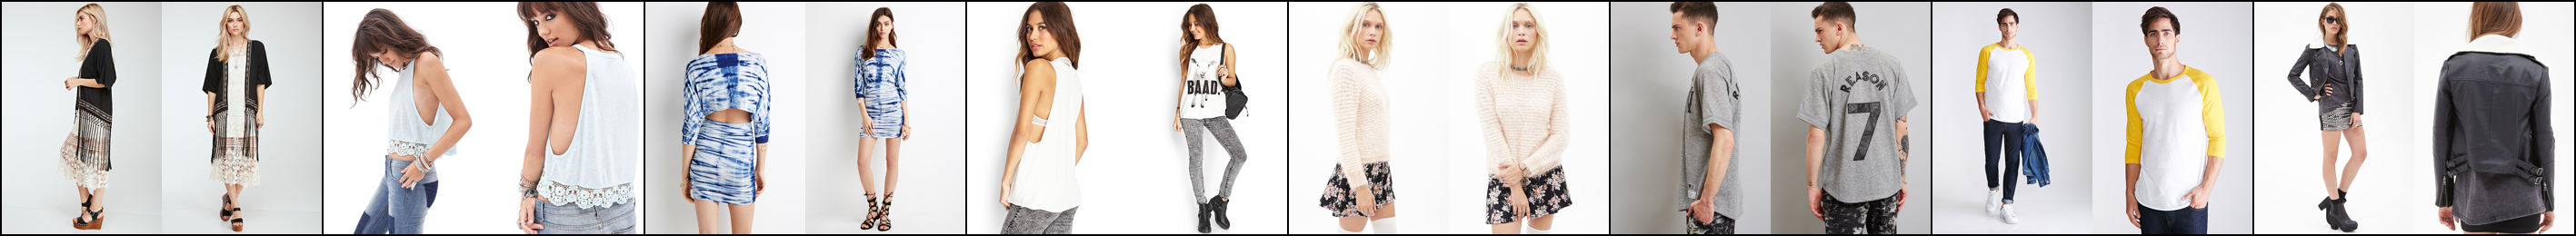

In [16]:
show_images( xb['src_tar'] )

In [17]:
len(train_dataset), len(train_dataloader)

(5000, 625)

# Fine-tuning

In [18]:
# TODO: add channel for mask or add channel for DINOv2 make in_channels = 9 || 10
# in_channels = [noisy_src_target_images  + src_img||mask + src_pose||tar_pose]
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", 
                                            torch_dtype=torch.float16, 
                                            in_channels=12,
                                            low_cpu_mem_usage=False,
                                            ignore_mismatched_sizes=True
                                           ).to(device)

An error occurred while trying to fetch SG161222/Realistic_Vision_V6.0_B1_noVAE: SG161222/Realistic_Vision_V6.0_B1_noVAE does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Some weights of UNet2DConditionModel were not initialized from the model checkpoint at SG161222/Realistic_Vision_V6.0_B1_noVAE and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([320, 4, 3, 3]) in the checkpoint and torch.Size([320, 12, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
import time

In [ ]:
n_epochs = 3
batch_size = 8
guidance_scale = 2.0
accumulation_steps = 4
num_batches = len(train_dataloader)
lr = 1e-4

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)


# Define the optimizer
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
loss_fn = nn.MSELoss()

losses = []

for epoch in range(n_epochs):
    for inputs in tqdm(train_dataloader):
        # 1. to device
        src_mask = inputs['src_mask'].half().to(device)
        st_pose = inputs['st_pose'].half().to(device)
        src_tar = inputs['src_tar'].half().to(device)
        # 2. get latents
        with torch.inference_mode():
            # masked_latents
            src_mask_latents = vae.encode(src_mask).latent_dist.sample() * 0.18215 
            # latents 
            src_tar_latents = vae.encode(src_tar).latent_dist.sample() * 0.18215 
            
            st_pose_latents = vae.encode(st_pose).latent_dist.sample() * 0.18215 
            
        # add noise
        noise = torch.randn_like(src_tar_latents, device=device)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (batch_size,), device=device, ).long()
        
        noisy_latents = scheduler.add_noise(src_tar_latents, noise, timesteps)
        noisy_latents = torch.cat([noisy_latents, src_mask_latents, st_pose_latents], dim=1)
        
        # Forward pass
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=combined_embeddings.repeat(batch_size, 1, 1)).sample
        
        # TODO: compute loss
        loss = loss_fn(noise_pred, src_tar_latents)
        
    break






# for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
#     # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
#     latent_model_input = torch.cat([latents] * 2)
#     # Scale the latents (preconditioning):
#     # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
#     latent_model_input = scheduler.scale_model_input(latent_model_input, t)

#     # predict the noise residual
#     with torch.no_grad():
#         noise_pred = unet(latent_model_input, t, encoder_hidden_states=combined_embeddings).sample

#     # perform guidance
#     noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#     noise_pred = noise_pred_uncond + 7.0 * (noise_pred_text - noise_pred_uncond)

#     # compute the previous noisy sample x_t -> x_t-1
#     # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
#     latents = scheduler.step(noise_pred, t, latents).prev_sample
    
# latents = 1 / 0.18215 * latents
# with torch.no_grad():
#     image = vae.decode(latents).sample

# # Display
# image = (image / 2 + 0.5).clamp(0, 1)
# image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
# images = (image * 255).round().astype("uint8")
# pil_images = [Image.fromarray(image) for image in images]
# pil_images[0]


  0%|          | 0/625 [00:00<?, ?it/s]